In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29682760.27it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


  cat  deer   car   car


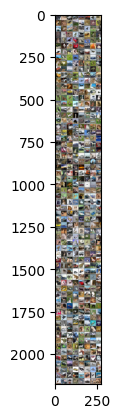

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
for images, labels in trainloader:
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
    imshow(torchvision.utils.make_grid(images))
    break




In [18]:
import torchvision.models.vgg as vgg

In [19]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

# 32, 16, 8, 4

In [20]:
# input을 32x32로 할꺼임
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) <이미지가 7*7 보다 작으면 x>
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [21]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device)

In [22]:
tmp_input = torch.Tensor(1,3,32,32).to(device)
tmp_output = vgg16(tmp_input)
print(tmp_output)
print(tmp_output.shape)

tensor([[-1.2896e-08, -3.7834e-09, -3.5394e-10, -1.7633e-08,  5.1507e-09,
          1.2103e-08,  1.9990e-08,  9.6252e-10,  1.7120e-08,  8.8656e-09]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [23]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

# 에폭이 길면, 러닝레이트 조절하기
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [24]:
# training
epochs = 30

for epoch in range(epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 30 == 29:
            print('Epoch: {:4d}, Cost: {:.6f}'.format(epoch, running_loss / 30))
            running_loss = 0.0
print('Learning Finished!')

Epoch:    0, Cost: 2.302146
Epoch:    0, Cost: 2.296959
Epoch:    0, Cost: 2.283443
Epoch:    1, Cost: 2.194935
Epoch:    1, Cost: 2.072814
Epoch:    1, Cost: 2.003061
Epoch:    2, Cost: 1.871688
Epoch:    2, Cost: 1.857875
Epoch:    2, Cost: 1.774839
Epoch:    3, Cost: 1.665644
Epoch:    3, Cost: 1.610701
Epoch:    3, Cost: 1.571419
Epoch:    4, Cost: 1.532189
Epoch:    4, Cost: 1.517789
Epoch:    4, Cost: 1.496506
Epoch:    5, Cost: 1.436030
Epoch:    5, Cost: 1.423102
Epoch:    5, Cost: 1.369411
Epoch:    6, Cost: 1.366618
Epoch:    6, Cost: 1.297795
Epoch:    6, Cost: 1.340756
Epoch:    7, Cost: 1.287965
Epoch:    7, Cost: 1.245458
Epoch:    7, Cost: 1.204575
Epoch:    8, Cost: 1.160929
Epoch:    8, Cost: 1.152156
Epoch:    8, Cost: 1.170381
Epoch:    9, Cost: 1.110015
Epoch:    9, Cost: 1.076654
Epoch:    9, Cost: 1.070817
Epoch:   10, Cost: 1.041006
Epoch:   10, Cost: 1.019756
Epoch:   10, Cost: 1.016715
Epoch:   11, Cost: 0.983866
Epoch:   11, Cost: 0.979524
Epoch:   11, Cost: 0

  cat plane  deer plane   cat
  cat truck  deer plane   dog


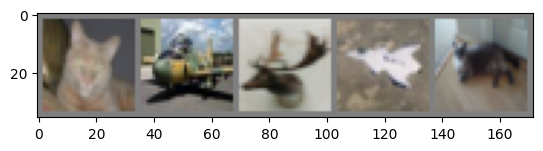

In [39]:
for images, labels in trainloader:
    print(' '.join('%5s' % classes[labels[j]] for j in range(5)))
    outputs = vgg16(images.to(device))
    predicted = torch.argmax(outputs, 1)
    print(' '.join('%5s' % classes[predicted[j]] for j in range(5)))
    imshow(torchvision.utils.make_grid(images[0:5]))
    break

In [36]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %
